## Forecast Benchmarking

This notebook serves to recreate the EPAG RNN forecast for Inlets 1 and 2 at Kubel, before training and evaluating a series of auxiliary ML models designed to be used in the context of a stacked ensemble model.

#### Import

In [49]:
import pandas as pd
import numpy as np
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from solutil import dbqueries as dbq
from solutil import evaluations as ev

#### Parameterization

In [7]:
# TS ID Assignment
act_inlet1 = 11127586
pred_inlet1 = 11055610

act_inlet2 = 11127590
pred_inlet2 = 11055614

In [11]:
# Parameter Assignment
date_from = datetime.strptime('01.03.2021', '%d.%m.%Y')
date_to = datetime.now() - timedelta(days=1)

In [15]:
# Load env variables
env_vars = dbq.get_env_variables(mandant='EPAG_ENERGIE')

#### TS Retrieval

In [19]:
# Inlet 1
df_act_inlet1 = dbq.get_timeseries_1h(act_inlet1, date_from, date_to, **env_vars)
df_pred_inlet1 = dbq.get_timeseries_1h(pred_inlet1, date_from, date_to, **env_vars)

In [22]:
# Inlet 2
df_act_inlet2 = dbq.get_timeseries_1h(act_inlet2, date_from, date_to, **env_vars)
df_pred_inlet2 = dbq.get_timeseries_1h(act_inlet1, date_from, date_to, **env_vars)

In [39]:
# Merge datasets
df_act_inlet1.name = 'act_inlet1'
df_inlets = df_act_inlet1.to_frame()
df_inlets['pred_inlet1'] = df_pred_inlet1
df_inlets['act_inlet2'] = df_act_inlet2
df_inlets['pred_inlet2'] = df_pred_inlet2

In [40]:
df_inlets

,act_inlet1,pred_inlet1,act_inlet2,pred_inlet2
Timestamp,,,,
2021-03-01 00:00:00+01:00,1.563610,1.807735,1.392077,1.563610
2021-03-01 01:00:00+01:00,1.572388,1.600004,1.392077,1.572388
2021-03-01 02:00:00+01:00,1.569493,1.433065,1.388438,1.569493
2021-03-01 03:00:00+01:00,1.560150,1.343673,1.378156,1.560150
2021-03-01 04:00:00+01:00,1.544482,1.315153,1.378861,1.544482
...,...,...,...,...
2024-05-21 03:00:00+01:00,3.422590,3.435886,1.333252,3.422590
2024-05-21 04:00:00+01:00,3.423851,3.450010,1.332569,3.423851
2024-05-21 05:00:00+01:00,3.467467,3.490950,1.399259,3.467467


### EPAG Model Evaluation

                        time variable     value
0  2021-03-01 00:00:00+01:00   actual  1.563610
1  2021-03-01 01:00:00+01:00   actual  1.572388
2  2021-03-01 02:00:00+01:00   actual  1.569493
3  2021-03-01 03:00:00+01:00   actual  1.560150
4  2021-03-01 04:00:00+01:00   actual  1.544482
5  2021-03-01 05:00:00+01:00   actual  1.529048
6  2021-03-01 06:00:00+01:00   actual  1.506113
7  2021-03-01 07:00:00+01:00   actual  1.467295
8  2021-03-01 08:00:00+01:00   actual  1.431388
9  2021-03-01 09:00:00+01:00   actual  1.408217
10 2021-03-01 10:00:00+01:00   actual  1.396221
11 2021-03-01 11:00:00+01:00   actual  1.394014
12 2021-03-01 12:00:00+01:00   actual  1.711159
13 2021-03-01 13:00:00+01:00   actual  1.943716
14 2021-03-01 14:00:00+01:00   actual  1.948851
15 2021-03-01 15:00:00+01:00   actual  1.956512
16 2021-03-01 16:00:00+01:00   actual  1.955453
17 2021-03-01 17:00:00+01:00   actual  1.956135
18 2021-03-01 18:00:00+01:00   actual  1.955681
19 2021-03-01 19:00:00+01:00   actual  1

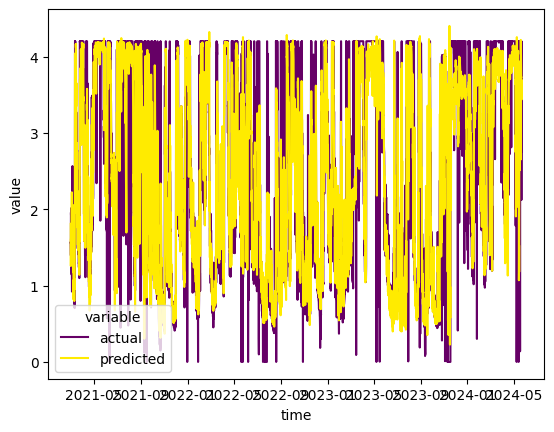

In [50]:
# Actual vs. Prediction Plot
fig = ev.get_act_vs_pred_plot(df_act_inlet1, df_pred_inlet1)

In [54]:
# Get Evaluation Metrics for Inlet 1 
inlet1_metrics = ev.get_eval_metrics(df_act_inlet1, df_pred_inlet1)
inlet1_metrics

{'mae': 0.4245331459009883,
 'mse': 0.4315773804177216,
 'rmse': 0.6569454927295884,
 'mape': 0.4245331459009883,
 'non-na%': 1.0,
 'n_actual_obs': 28256,
 'n_pred_nas': 24}

In [55]:
# Get Evaluation Metrics for Inlet 2
inlet2_metrics = ev.get_eval_metrics(df_act_inlet2, df_pred_inlet2)
inlet2_metrics

{'mae': 0.5714573926626269,
 'mse': 0.6837778705824867,
 'rmse': 0.8269086228734628,
 'mape': 0.5714573926626269,
 'non-na%': 1.0,
 'n_actual_obs': 28256,
 'n_pred_nas': 0}